In [1]:
import os  
import torch  
from torch.utils.data import DataLoader, random_split  
import pytorch_lightning as pl  
from trainer.imagefusion_new import ImageFusionTrainer  
from data_loader.dataloader import HyperspectralMultispectralDataset  
from model.MSDCNN import MSDCNN  
import numpy as np  # 导入NumPy用于数组处理  

cpu_count = os.cpu_count()  
root_path = './data'  

# 创建模型实例  
model = MSDCNN(scale=8, hsi_channels=128, msi_channels=3)  

# 加载最佳模型  
best_model = ImageFusionTrainer.load_from_checkpoint(  
    r'D:\Study\大三\leida\chaofen\logs\logs_MSDCNN\experiment\version_1\checkpoints\best_model_epochepoch=1599-val_lossval_loss=0.01.ckpt',  
    model=model)  

# 将模型移到正确的设备  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
best_model.to(device)  

# 创建数据集实例  
dataset = HyperspectralMultispectralDataset(root_path=root_path, window_size=40, verbose=True)  

# 设定随机数  
generator2 = torch.Generator().manual_seed(42)  

# 划分数据集  
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=generator2)  

# DataLoader 设置，使用 pin_memory 提升数据加载效率  
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=cpu_count // 2, persistent_workers=True, pin_memory=True)  
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=cpu_count // 2, persistent_workers=True, pin_memory=True)  

# 进行预测  
predictions = []  
truth = []  
best_model.eval()  # 切换到评估模式  
with torch.no_grad():  
    for batch in val_loader:  
        # 将数据移动到 GPU  
        HR = batch['HR'].to(device)  # 将 HR 移动到 GPU  
        # 如果 batch 中还有其他数据，也可以同行移动  
        for key in batch:  
            batch[key] = batch[key].to(device)  # 将其它数据也移到 GPU  

        # 调用模型进行预测  
        preds = best_model(batch)  
        predictions.append(preds.cpu().numpy())  # 转移到CPU并转换为NumPy数组  
        truth.append(HR.cpu().numpy())  # 转移到CPU并转换为NumPy数组  

# 将 predictions 和 truth 转换为 NumPy 数组  
predictions = np.concatenate(predictions, axis=0)  # 联合预测数组  
truth = np.concatenate(truth, axis=0)  # 联合真实值数组  

d:\anaconda\envs\leida\lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
d:\anaconda\envs\leida\lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Found 1 .mat files in ./data


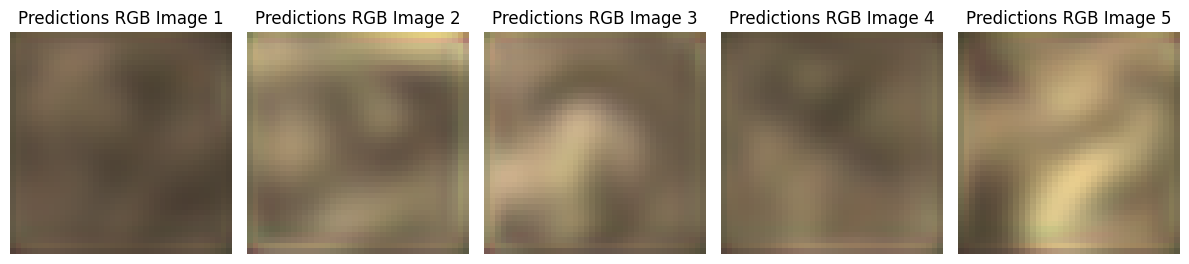

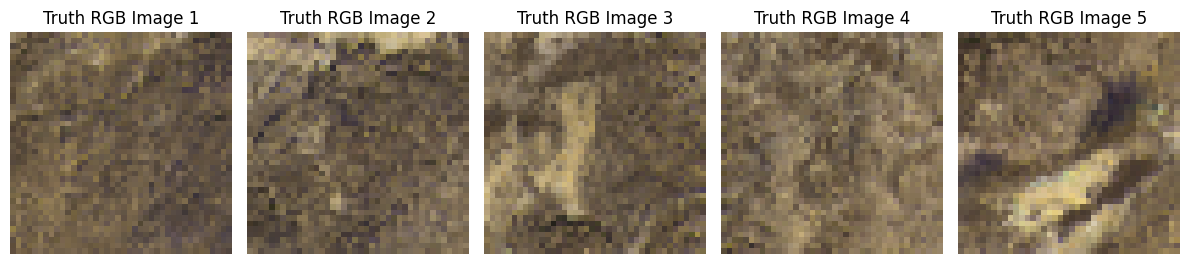

In [2]:
import numpy as np  
import matplotlib.pyplot as plt  

# 假设 predictions 和 truth 是形状为 (5, 128, 40, 40) 的数组  
# 选择 RGB 波段，选定的波段索引  
R_band_index = 60  # 红色波段索引  
G_band_index = 50  # 绿色波段索引  
B_band_index = 40  # 蓝色波段索引  

# 提取 RGB 波段的函数  
def extract_rgb(data):  
    # 创建一个新的数组来存储 RGB 图像，形状为 (num_samples, height, width, 3)  
    rgb = np.zeros((data.shape[0], data.shape[2], data.shape[3], 3))  
    
    # 从输入数据中提取 R, G, B 波段，并确保值在 [0, 1] 之间  
    rgb[..., 0] = np.clip(data[:, R_band_index, :, :], 0, 1)  # 提取红色波段  
    rgb[..., 1] = np.clip(data[:, G_band_index, :, :], 0, 1)  # 提取绿色波段  
    rgb[..., 2] = np.clip(data[:, B_band_index, :, :], 0, 1)  # 提取蓝色波段  
    
    return rgb  # 返回 RGB 图像数组  

# 提取预测和真实值的 RGB 图像  
predictions_rgb = extract_rgb(predictions)  # 从预测数据中提取 RGB 图像  
truth_rgb = extract_rgb(truth)  # 从真实值数据中提取 RGB 图像  

# 绘制预测图像  
plt.figure(figsize=(12, 6))  # 设置绘图窗口大小  
for i in range(predictions_rgb.shape[0]):  # 遍历每张预测图像  
    plt.subplot(1, predictions_rgb.shape[0], i + 1)  # 创建子图  
    plt.imshow(predictions_rgb[i])  # 显示 RGB 图像  
    plt.title(f'Predictions RGB Image {i + 1}')  # 设置标题  
    plt.axis('off')  # 关闭坐标轴  

plt.tight_layout()  # 自动调整子图参数以填充整个图像区域  
plt.show()  # 显示预测图像  

# 绘制真实图像  
plt.figure(figsize=(12, 6))  # 设置绘图窗口大小  
for i in range(truth_rgb.shape[0]):  # 遍历每张真实图像  
    plt.subplot(1, truth_rgb.shape[0], i + 1)  # 创建子图  
    plt.imshow(truth_rgb[i])  # 显示 RGB 图像  
    plt.title(f'Truth RGB Image {i + 1}')  # 设置标题  
    plt.axis('off')  # 关闭坐标轴  

plt.tight_layout()  # 自动调整子图参数以填充整个图像区域  
plt.show()  # 显示真实图像